<img src="../extra/images/Beyond_Grades_Banner_01.png" width="100%">

# 📚 <model_evaluation> INDEX

- [1 - IMPORTS](#1---IMPORTS)
    - [1.1 - Setup Project](#11---setup-project)

- [2 - DATASET LOAD](#2---DATASET-LOAD)
    - [2.1 - Loading](#21---loading)

- [3 - MODELING](#3---MODELING)
    - [3.1 - Baseline](#21---loading)

---
# 1 - IMPORTS

### 1.1 - SETUP PROJECT

In [2]:
# Centralized setup
import sys
from pathlib import Path

# Make sure PROJECT_PATH is in sys
PROJECT_ROOT = Path.cwd().resolve().parent
PROJECT_PATH = PROJECT_ROOT / "src" / "project"

if str(PROJECT_PATH) not in sys.path:
    sys.path.insert(0, str(PROJECT_PATH))

# Centralized import
from imports import *

cleaning.py functions module imported from: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\src\data
preprocessing.py functions module imported from: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\src\data
splitting.py functions module imported from: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\src\data
analysis.py functions module imported from: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\src\features
utils.py functions module imported from: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\U

---
# 2 - DATASET LOAD

### 2.1 - LOADING

In [3]:
X_train_path = "../data/processed/01_X_train_feat_engeneered.xlsx"
y_train_path = "../data/interim/02_y_train_aftersplit.xlsx"

X_test_path = "../data/processed/01_X_test_feat_engeneered.xlsx"
y_test_path = "../data/interim/02_y_test_aftersplit.xlsx"

try:
    X_train = utils.load_student_dataset(X_train_path)
    print('X_train successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

try:
    y_train = utils.load_student_dataset(y_train_path)
    print('y_train loaded successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

try:
    X_test = utils.load_student_dataset(X_test_path)
    print('X_test successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

try:
    y_test = utils.load_student_dataset(y_test_path)
    print('y_test loaded successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

X_train successfully.
y_train loaded successfully.
X_test successfully.
y_test loaded successfully.


---
# 3 - MODELING

### 3.1 - BASELINE

**Baseline Model**

Before I start testing more sophisticated models, I want to establish a **baseline**.  
The baseline gives me a simple benchmark: if my machine learning models can’t do better than this, then something is clearly wrong with either my features or my modeling approach.

**My baseline strategy**

Since this is a regression task, I will use the simplest possible predictor:  
**always predict the mean** of the training target (`y_train`).  
This is like me saying:  
> “No matter who the student is, I’ll just guess their GPA is about the average of the training set.”

**Steps I follow**
1. I compute the **mean GPA** from my training data.  
2. For every student in the test set, I predict this mean value.  
3. I then evaluate these predictions using standard error metrics:
   - **RMSE** (Root Mean Squared Error) - This is like the "average size of the mistake," but big errors count extra because they are squared. If RMSE is low, the model rarely makes very large mistakes.  
   - **MAE** (Mean Absolute Error) - This is the average absolute difference between predictions and the real values. Easier to interpret, but it does not punish big mistakes as much as RMSE.
   - **R²** (Coefficient of Determination) - This tells us how much of the variation in the data the model can explain. R² = 1.0 means perfect predictions, R² = 0 means the model is no better than guessing the mean, and negative values mean it performs worse than the baseline.

**How to read them together**
Lower RMSE and MAE are better, since they mean smaller errors.
Higher R² is better, since it means the model explains more of the data.
RMSE and MAE show how far off the predictions are, while R² shows how accurate the model is overall.

**What I expect**
- **RMSE / MAE** should be relatively high, since many students deviate from the mean.  
- **R²** will be close to 0, or even negative if the test mean differs from the training mean.  

Even though this baseline is simple (and bad), it’s important:  
- It gives me a **minimum benchmark**.  
- Any useful regression model I build should clearly beat this by showing **lower RMSE/MAE** and a **higher R²**.

In [4]:
baseline_pred, baseline_metrics = preprocessing.baseline_mean_model(y_train, y_test)

# Print results
print("Baseline (Mean Predictor)")
print(f"RMSE: {baseline_metrics['RMSE']:.4f}")
print(f"MAE:  {baseline_metrics['MAE']:.4f}")
print(f"R²:   {baseline_metrics['R2']:.4f}")

Baseline (Mean Predictor)
RMSE: 0.9252
MAE:  0.7843
R²:   -0.0000


As expected, the baseline model has a very poor performance. 
1. **RMSE ≈ 0.9252**

This means that, on average, the baseline predictions (always predicting the training mean) are off by about 0.93 GPA units in squared-error sense.
RMSE penalizes larger errors more heavily.

2. **MAE ≈ 0.7843**

On average, the absolute difference between the predicted mean GPA and the actual GPAs in the test set is 0.78.
More intuitive than RMSE: “on average I’m ~0.8 GPA points wrong.”

3. **R² ≈ -0.0000**

R² is basically 0 (slightly negative due to tiny numerical differences).
Interpretation: this baseline explains no variance in the target.The best the model can do is guessing the average value every time.

This is *exactly what I expected*: predicting a constant (the mean) gives R² = 0 by definition and can dip slightly below zero if the test mean differs from the train mean.

### 3.2 - MODELS TRAINING AND COMPARISON

After setting the baseline, it’s time to move into the real modeling stage.  
Here I train and compare a set of regression algorithms on the student engagement dataset.  

To evaluate fairly, I use **5-fold cross-validation** on the training set: the data is split into 5 parts, the model is trained on 4 parts and validated on the remaining one, and the process repeats until every fold has been used.  
This gives me a reliable estimate of how each model performs before I select the best candidate to test on the unseen test set.

The models I will try, explained in simple terms and with analogies:

**Linear Regression (plus Ridge / Lasso)**  
Linear regression searches for the best straight-line (or flat surface in many dimensions) relationship between the input features and 'GPA'.  
- Ridge and Lasso are stricter versions that shrink large coefficients, preventing the model from chasing every small fluctuation.  
- They help keep the model simpler and more stable.  

> Analogy: drawing a smooth line through a cloud of points. Ridge and Lasso act like weights keeping the line steady so it doesn’t bend too much to follow one odd outlier.

**Decision Tree**  
Decision trees split the data into groups by asking a sequence of yes/no questions.  
For example: *Does the student study more than 5 hours per week?* If yes, go one way; if no, go another, and continue until a prediction is made.  

> Analogy: a checklist a teacher might use - *If the student studies a lot and rarely misses school, assume a higher GPA. Otherwise, follow the next question down the list…*

**Random Forest**  
A random forest combines the predictions of many different decision trees.  
Each tree sees a slightly different version of the data, and their answers are averaged to reduce the effect of noise or bias.  

> Analogy: instead of trusting one teacher’s opinion, I ask a panel of teachers and average their GPA predictions. The diversity of viewpoints produces a more balanced result.

**Gradient Boosting Regressor**  
Gradient boosting also uses trees but in a step-by-step manner.  
The first tree makes a rough guess, the next tree learns from its mistakes, and each new tree keeps improving on the previous ones.  

> Analogy: a student with several tutors in sequence - the first covers the basics, the next focuses on weaknesses, the last fills remaining gaps, until mastery is reached.

**Support Vector Regression (SVR)**  
SVR fits a line or curve through the data but allows a margin of tolerance.  
It focuses on capturing the overall trend instead of fitting every point exactly.  

> Analogy: stretching an elastic band across scattered data points - it won’t snap to each one, but follows the overall shape.

**k-Nearest Neighbors (KNN) Regression**  
KNN predicts 'GPA' by finding the 'k' most similar students in the training data and averaging their outcomes.  
For example, with 'k=5', the model looks for 5 students with similar study time, absences, or support, and uses their average GPA as the prediction.  

> Analogy: moving to a new class and asking 5 classmates who are most like you what grades they got — averaging their answers gives you a reasonable guess.

By comparing these different approaches, I can see which algorithm captures the patterns in the data best.  
Each method has unique strengths, and evaluating them side by side provides both **insight into the problem** and a **solid performance benchmark**.


In [5]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import pandas as pd


def run_model_suite(
    X_train, y_train,
    numeric_features, categorical_features,
    models: dict | None = None,
    k_best: int | None = 12,
    cv_splits: int = 5,
    X_test=None, y_test=None,
):
    """
    Simple end-to-end: CV-compare models -> pick best by RMSE -> refit on full train.
    Optionally evaluate on test. Returns (results_df, best_name, best_pipe, test_metrics).

    - Uses `create_pipeline(numeric_features, categorical_features, k_best, model)`
      so preprocessing + SelectKBest happen inside CV (CV-safe).
    - If X_test and y_test are provided, computes RMSE/MAE/R2 on test for the best model.
    """
    if models is None:
        models = {
            "Linear": LinearRegression(),
            "Ridge": Ridge(alpha=1.0),
            "Lasso": Lasso(alpha=0.01, max_iter=10000),
            "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000),
            "DecisionTree": DecisionTreeRegressor(random_state=42),
            "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
            "GradientBoosting": GradientBoostingRegressor(random_state=42),
            "SVR": SVR(kernel="rbf", C=1.0, epsilon=0.1),
            "KNN": KNeighborsRegressor(n_neighbors=5),
        }

    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    # Version-proof RMSE via sqrt(MSE); make_scorer returns "higher is better" by default,
    # so I negate later to keep RMSE positive and sortable.
    rmse_scorer = make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)))
    mae_scorer  = make_scorer(mean_absolute_error)
    r2_scorer   = make_scorer(r2_score)

    rows = []
    for name, model in models.items():
        pipe = preprocessing.create_pipeline(
            numeric_features=numeric_features,
            categorical_features=categorical_features,
            k_best=k_best,
            model=model
        )

        scores = cross_validate(
            pipe, X_train, y_train.squeeze(),
            cv=kf,
            scoring={"rmse": rmse_scorer, "mae": mae_scorer, "r2": r2_scorer},
            return_train_score=False,
            error_score="raise"
        )

        rmse_mean = scores["test_rmse"].mean()
        mae_mean  = scores["test_mae"].mean()
        r2_mean   = scores["test_r2"].mean()
        rows.append((name, rmse_mean, mae_mean, r2_mean))

    results_df = pd.DataFrame(rows, columns=["Model", "RMSE", "MAE", "R2"]).sort_values("RMSE")
    best_name = results_df.iloc[0]["Model"]

    # Refit best on full train
    best_pipe = preprocessing.create_pipeline(
        numeric_features=numeric_features,
        categorical_features=categorical_features,
        k_best=k_best,
        model=models[best_name]
    ).fit(X_train, y_train.squeeze())

    test_metrics = None
    if X_test is not None and y_test is not None:
        y_pred = best_pipe.predict(X_test)
        mse  = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y_test, y_pred)
        r2   = r2_score(y_test, y_pred)
        test_metrics = {"RMSE": rmse, "MAE": mae, "R2": r2}

    return results_df, best_name, best_pipe, test_metrics




In [6]:
# Define feature lists first
numeric_features = [
    "Age", "StudyTimeWeekly", "Absences",
    "FamilyCapitalScore", "EngagementIndex"
]

categorical_features = [
    "Gender", "Ethnicity", "ParentalEducation", "Tutoring",
    "ParentalSupport", "Extracurricular", "Sports", "Music", "Volunteering"
]

results_df, best_name, best_pipe, test_metrics = run_model_suite(
    X_train, y_train,
    numeric_features, categorical_features,
    k_best=12,
    cv_splits=5,
    X_test=None, y_test=None  # optional
)

print("\n Metrics Summary (lower RMSE/MAE is better, higher R² is better):\n")
print(results_df.to_string(index=False))
print("\nBest by CV RMSE:", best_name)
if test_metrics:
    print("Test metrics:", {k: round(v, 4) for k, v in test_metrics.items()})



 Metrics Summary (lower RMSE/MAE is better, higher R² is better):

           Model     RMSE      MAE       R2
           Ridge 0.223587 0.179917 0.939816
          Linear 0.223604 0.179907 0.939807
      ElasticNet 0.227521 0.183403 0.937673
           Lasso 0.235385 0.189224 0.933269
GradientBoosting 0.236361 0.188482 0.932734
             SVR 0.241486 0.193241 0.929823
    RandomForest 0.262306 0.208827 0.917063
             KNN 0.312129 0.249955 0.882559
    DecisionTree 0.364845 0.291909 0.839062

Best by CV RMSE: Ridge


In [ ]:
all_names, scores, mask, selected = preprocessing.get_selected_features(best_pipe, numeric_features, categorical_features)
print("\nSelected features (final fit):", selected[:25], "..." if len(selected) > 25 else "")


Selected features (final fit): ['StudyTimeWeekly', 'Absences', 'FamilyCapitalScore', 'Tutoring_0', 'Tutoring_1', 'ParentalSupport_0', 'ParentalSupport_3', 'ParentalSupport_4', 'Extracurricular_0', 'Extracurricular_1', 'Music_0', 'Music_1'] 


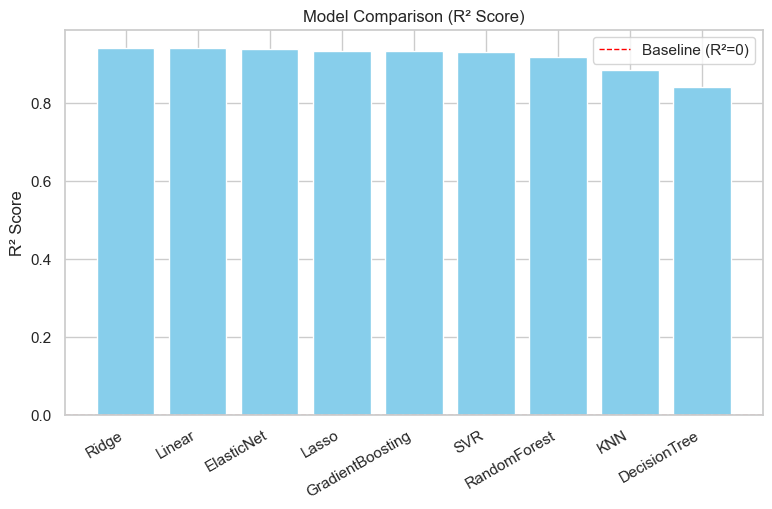

In [8]:
preprocessing.plot_model_r2(results_df)  # automatically extracts Model vs R2

**Top performers (Ridge, Linear, ElasticNet)**

>- Ridge (RMSE = 0.224, R² = 0.940) and Linear Regression (RMSE = 0.224, R² = 0.940) are essentially tied.

>- ElasticNet is very close behind (RMSE ≈ 0.228, R² ≈ 0.938).

This means the data has strong linear relationships with GPA and regularized linear models capture them very well.

Ridge slightly edges out plain Linear Regression (by ~0.00002 in RMSE!) — practically identical performance, but Ridge gives a bit more stability if features are correlated.

**Middle ground (Lasso, GradientBoosting, SVR)**

>- Lasso (RMSE = 0.235, R² = 0.933) lags slightly: it forces some coefficients to zero, which may have thrown away small but useful features.

>- Gradient Boosting (RMSE = 0.236, R² = 0.933) and SVR (RMSE = 0.241, R² = 0.930) also perform well but not better than linear models.

This suggests the dataset doesn’t benefit much from complex nonlinear models — the structure is mostly linear.

**Weaker models (RandomForest, KNN, DecisionTree)**

>-Random Forest (RMSE = 0.262, R² = 0.917) does okay but worse than linear models.

>-KNN (RMSE = 0.312, R² = 0.883) and Decision Tree (RMSE = 0.365, R² = 0.839) perform significantly worse.

These models may be struggling because GPA is smooth and continuous, and simple distance- or split-based learners can’t capture it as well without very careful tuning.

**Key takeaway**

>- Linear models dominate: Ridge, plain Linear, and ElasticNet are the clear winners.

>- The fact that Ridge/Linear are better than Gradient Boosting and Random Forest shows the target (GPA) is strongly tied to linear effects of the features.

>- Regularization (Ridge, ElasticNet) helps ensure stability, but doesn’t drastically change results because the data seems clean and well-structured.

### 3.3 - HYPERPARAMETER TUNING

Default settings are a reasonable starting point, but they’re rarely optimal.  
Here I tune the main hyperparameters of the linear family that worked best so far: 'Ridge' (strength 'alpha') and 'ElasticNet' (both 'alpha' and 'l1_ratio'). Linear Regressor has no hyperparameters.

**What I do**
- I wrap preprocessing and modeling in one pipeline so tuning is cross-validation safe.
- I use 5-fold cross-validation and optimize for **RMSE** (lower is better).
- I compare the tuned scores against the defaults, then keep the best configuration.

> Why this matters: the regularization strength controls how much the model shrinks coefficients. Too little → noisy, too much → underfit. Tuning finds the sweet spot for this dataset.

**Outcome I expect**
- A small but consistent improvement over defaults for 'Ridge'.
- For 'ElasticNet', a useful check whether adding L1 (sparsity) helps or not in this data.


In [9]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Ridge, ElasticNet
import numpy as np
import pandas as pd

# Version-proof RMSE scorer (negative because GridSearchCV maximizes the score)
_rmse_scorer = make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)), greater_is_better=False)

def tune_model(
    X_train, y_train,
    numeric_features, categorical_features,
    model, param_grid,
    k_best=12, cv_splits=5, n_jobs=-1, verbose=0, random_state=42
):
    """
    Grid-search a model inside your create_pipeline (CV-safe).
    Returns: best_pipe (fitted), best_params (dict), results_df (with RMSE), grid (GridSearchCV object).
    """
    # Build CV
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # Wrap model with your preprocessing + optional SelectKBest
    pipe = preprocessing.create_pipeline(
        numeric_features=numeric_features,
        categorical_features=categorical_features,
        k_best=k_best,
        model=model
    )

    # Grid search
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=_rmse_scorer,
        cv=cv,
        n_jobs=n_jobs,
        refit=True,            # refit best on full training set automatically
        return_train_score=True,
        verbose=verbose,
        error_score="raise"
    )
    grid.fit(X_train, y_train.squeeze())

    # Results as a tidy DataFrame
    res = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score")
    res["mean_test_RMSE"]  = -res["mean_test_score"]
    res["std_test_RMSE"]   =  res["std_test_score"]
    if "mean_train_score" in res:
        res["mean_train_RMSE"] = -res["mean_train_score"]

    keep_cols = [c for c in [
        "rank_test_score", "mean_test_RMSE", "std_test_RMSE", "mean_train_RMSE", "params"
    ] if c in res.columns]
    results_df = res[keep_cols].reset_index(drop=True)

    best_pipe   = grid.best_estimator_
    best_params = grid.best_params_
    best_rmse   = -grid.best_score_

    print("✅ Best params:", best_params)
    print(f"✅ Best CV RMSE: {best_rmse:.6f}")

    return best_pipe, best_params, results_df, grid


In [10]:
# Linear has no hyperparameters

In [ ]:
from sklearn.linear_model import Ridge, ElasticNet

# Define your feature lists first
# numeric_features = [...]
# categorical_features = [...]

# 1) Ridge tuning
ridge_params = {"model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_best_pipe, ridge_best_params, ridge_results, ridge_grid = tune_model(
    X_train, y_train,
    numeric_features, categorical_features,
    model=Ridge(),
    param_grid=ridge_params,
    k_best=12, cv_splits=5
)

# 2) ElasticNet tuning
elastic_params = {
    "model__alpha":    [0.001, 0.01, 0.1, 1.0, 10.0],
    "model__l1_ratio": [0.2, 0.5, 0.8]
}
elastic_best_pipe, elastic_best_params, elastic_results, elastic_grid = tune_model(
    X_train, y_train,
    numeric_features, categorical_features,
    model=ElasticNet(max_iter=10000),
    param_grid=elastic_params,
    k_best=12, cv_splits=5
)

✅ Best params: {'model__alpha': 1.0}
✅ Best CV RMSE: 0.223587
✅ Best params: {'model__alpha': 0.001, 'model__l1_ratio': 0.2}
✅ Best CV RMSE: 0.223584


'\n# Evaluate best on test (example with Ridge)\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\ny_pred = ridge_best_pipe.predict(X_test)\nrmse = np.sqrt(mean_squared_error(y_test, y_pred))\nmae  = mean_absolute_error(y_test, y_pred)\nr2   = r2_score(y_test, y_pred)\nprint("\nTest set (Ridge best):")\nprint(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")\n'

### 3.4 - FINALIZE MODEL

After tuning, I am now reusing the best pipeline with the chosen parameters for Ridge and re-fitting on the entire `X_train` and `y_train` without any cross-validation. This will give my final model. 

In [12]:
final_pipe = preprocessing.create_pipeline(
     numeric_features, categorical_features,
     k_best=12,
     model=Ridge(alpha=ridge_best_params["model__alpha"])
 )

final_pipe.fit(X_train, y_train.squeeze())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'StudyTimeWeekly',
                                                   'Absences',
                                                   'FamilyCapitalScore',
                                                   'EngagementIndex']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Ethnicity',
                                                   'ParentalEducation',
                                                   'Tutoring',
                                                   'ParentalSupport',
                                                   'Extracurricular', 'Sports',
                                                   'Music',
                                                   'Volunteering'])])),
                ('select',
                 SelectKBest(k=12,
                             score_func=<function f_regression at 0x00000277AB9E5EE0>)),
                ('model', Ridge())])

### 3.5 - EVALUATE ON TEST SET

In [13]:
y_pred = final_pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("Final Ridge on test:")
print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

Final Ridge on test:
RMSE: 0.2184 | MAE: 0.1740 | R²: 0.9443


In [17]:
from pathlib import Path
import numpy as np

# after you computed: rmse, mae, r2 and have final_pipe, ridge_best_params
all_names, scores, mask, selected = preprocessing.get_selected_features(final_pipe, numeric_features, categorical_features)

# Create dict with final results
report = {
    "Final Model Report – Ridge Regression": {
        "Best Parameters": {
            "alpha": float(ridge_best_params["model__alpha"]),
            "k_best": 12
        },
        "Test Set Metrics": {
            "RMSE": float(rmse),
            "MAE":  float(mae),
            "R2":   float(r2),
        },
        "Features": {
            "Numeric": numeric_features,
            "Categorical": categorical_features,
            "Selected After Fit": selected
        },
        "Notes": (
            "Ridge tuned with 5-fold CV. "
            f"Generalizes well (R²≈{r2:.3f}). "
            "Linear models outperform non-linear ones in this dataset."
        )
    }
}

# Saves to .md file
utils.save_report_md(report, "final_ridge_report.md")
print("Saved Markdown report as final_ridge_report.md")


Report saved to: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\outputs\reports\final_ridge_report.md
Saved Markdown report as final_ridge_report.md


### 3.6 - Diagnostic & Intepretation

**Diagnostics and Interpretation**

To trust the model, I look beyond the score and inspect *how* it makes errors and *which* features drive predictions.

**What I check**
- Residuals: they should look like random noise around zero.
- Predicted vs actual: points should cluster near the diagonal.
- Error distribution: no extreme skew or fat tails.
- Subgroups: are errors bigger for some groups (e.g., 'Gender', 'ParentalEducation', 'Ethnicity')?
- Feature contributions: which inputs matter most (coefficients, permutation importance)?

> If residuals show structure (curvature, funnel shapes), the model may be missing nonlinearity or suffering from heteroscedasticity. If subgroup errors differ, I note potential fairness concerns and discuss mitigation.


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assumes: final_pipe (fitted), X_test, y_test, numeric_features, categorical_features
# helper names from earlier: get_selected_features

def make_residuals_df(pipeline, X, y_true):
    y_true = np.ravel(y_true)
    y_pred = pipeline.predict(X)
    resid  = y_true - y_pred
    return pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "residual": resid})

res_df = make_residuals_df(final_pipe, X_test, y_test)
res_df.head()


,y_true,y_pred,residual
0,1.666702,1.747419,-0.080717
1,2.370067,2.094415,0.275652
2,1.757092,1.676629,0.080462
3,1.217873,0.746585,0.471288
4,1.574306,1.625428,-0.051122


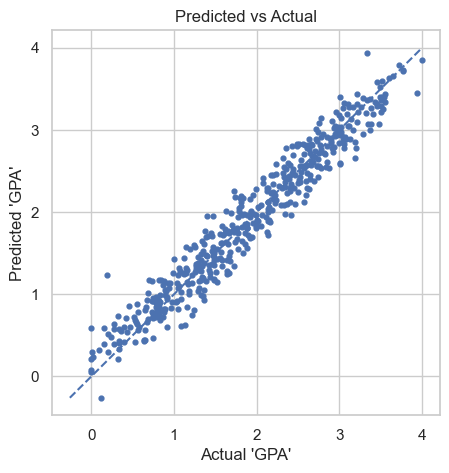

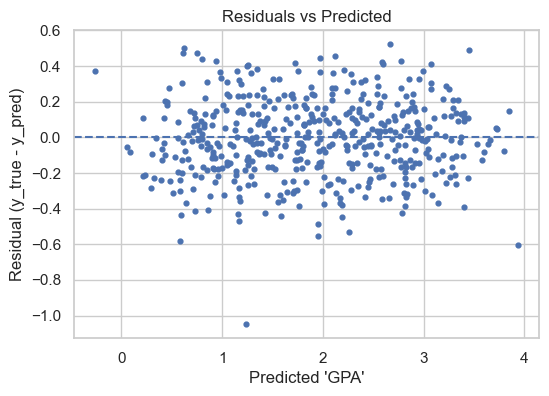

In [19]:
# Predicted vs Actual
plt.figure(figsize=(5,5))
plt.scatter(res_df["y_true"], res_df["y_pred"], s=12)
min_v = min(res_df["y_true"].min(), res_df["y_pred"].min())
max_v = max(res_df["y_true"].max(), res_df["y_pred"].max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")
plt.xlabel("Actual 'GPA'")
plt.ylabel("Predicted 'GPA'")
plt.title("Predicted vs Actual")
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(res_df["y_pred"], res_df["residual"], s=12)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted 'GPA'")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residuals vs Predicted")
plt.show()


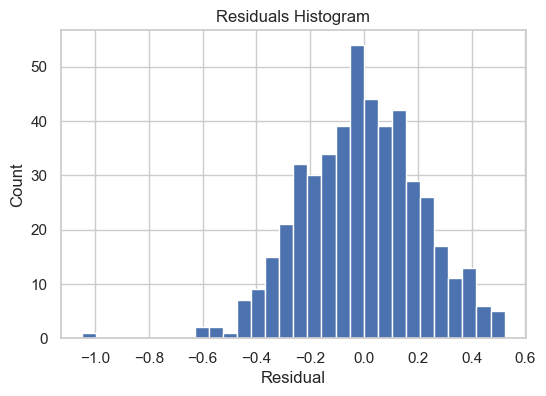

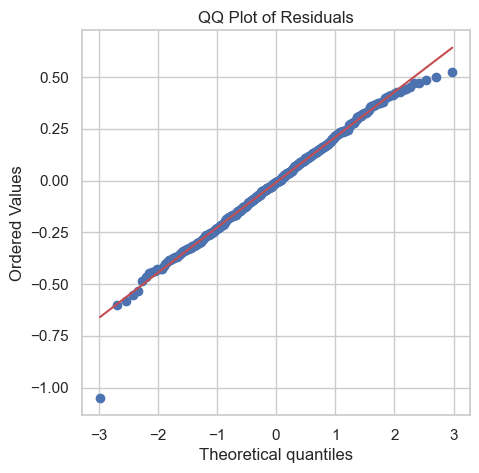

In [20]:
plt.figure(figsize=(6,4))
plt.hist(res_df["residual"], bins=30)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residuals Histogram")
plt.show()

# QQ-plot (optional)
try:
    from scipy import stats
    plt.figure(figsize=(5,5))
    stats.probplot(res_df["residual"], dist="norm", plot=plt)
    plt.title("QQ Plot of Residuals")
    plt.show()
except Exception as e:
    print("QQ plot skipped (scipy not available):", e)


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_by_group(pipeline, X, y, group_col):
    # group_col must be a column in X (categorical or binned numeric)
    df = X.copy()
    df["_y_true"] = np.ravel(y)
    df["_y_pred"] = pipeline.predict(X)
    df["_abs_err"] = np.abs(df["_y_true"] - df["_y_pred"])
    # RMSE per group
    rows = []
    for g, sub in df.groupby(group_col):
        rmse = np.sqrt(mean_squared_error(sub["_y_true"], sub["_y_pred"]))
        mae  = mean_absolute_error(sub["_y_true"], sub["_y_pred"])
        rows.append((g, rmse, mae, len(sub)))
    return pd.DataFrame(rows, columns=[group_col, "RMSE", "MAE", "Count"]).sort_values("RMSE")

# Pick relevant groups from your dataset:
group_cols = ["Gender", "ParentalEducation", "Ethnicity", "Extracurricular", "Sports", "Music", "Volunteering"]

group_reports = {}
for gc in group_cols:
    if gc in X_test.columns:
        group_reports[gc] = evaluate_by_group(final_pipe, X_test, y_test, gc)

# Example: view one table
group_reports.get("Gender", pd.DataFrame())


,Gender,RMSE,MAE,Count
1,1,0.212279,0.171751,264
0,0,0.225757,0.176860,215


In [23]:
# Get post-preprocess feature names (after OHE and selection)
all_names, scores, mask, selected_names = preprocessing.get_selected_features(final_pipe, numeric_features, categorical_features)

# Extract coefficients from the final model
model = final_pipe.named_steps["model"]
coefs = getattr(model, "coef_", None)

if coefs is not None:
    coef_df = pd.DataFrame({"feature": selected_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

    print("Top positive contributors:")
    print(coef_df_sorted[coef_df_sorted["coef"] > 0].head(10).to_string(index=False))

    print("\nTop negative contributors:")
    print(coef_df_sorted[coef_df_sorted["coef"] < 0].head(10).to_string(index=False))
else:
    print("Coefficients not available for this model type.")


Top positive contributors:
           feature     coef  abs_coef
 ParentalSupport_4 0.320065  0.320065
 ParentalSupport_3 0.184430  0.184430
   StudyTimeWeekly 0.170916  0.170916
        Tutoring_1 0.124540  0.124540
 Extracurricular_1 0.093224  0.093224
           Music_1 0.075092  0.075092
FamilyCapitalScore 0.020836  0.020836

Top negative contributors:
          feature      coef  abs_coef
         Absences -0.830968  0.830968
ParentalSupport_0 -0.230853  0.230853
       Tutoring_0 -0.124540  0.124540
Extracurricular_0 -0.093224  0.093224
          Music_0 -0.075092  0.075092


In [26]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

# 1) Get names AFTER preprocess + selection
all_names, scores, mask, selected_names = preprocessing.get_selected_features(
    final_pipe, numeric_features, categorical_features
)

# 2) Transform X_test the same way the pipeline does
pre = final_pipe.named_steps["preprocessor"]
X_tx = pre.transform(X_test)

sel = final_pipe.named_steps.get("select", None)
if sel is not None and sel != "passthrough":
    X_tx = sel.transform(X_tx)

# 3) Use the final model (not the whole pipeline)
model = final_pipe.named_steps["model"]

# 4) Permutation importance on the transformed matrix
perm = permutation_importance(
    model,
    X_tx,
    np.ravel(y_test),
    n_repeats=10,
    random_state=42,
    scoring="r2",
)

# 5) Build a matching DataFrame
pi = pd.DataFrame({
    "feature": selected_names,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std,
}).sort_values("importance_mean", ascending=False)

print(pi.head(15).to_string(index=False))



           feature  importance_mean  importance_std
          Absences         1.737226        0.077994
   StudyTimeWeekly         0.053542        0.005594
 ParentalSupport_4         0.025672        0.002148
 ParentalSupport_3         0.017492        0.002078
        Tutoring_0         0.007164        0.001058
        Tutoring_1         0.007164        0.001058
 ParentalSupport_0         0.006274        0.000987
 Extracurricular_0         0.004162        0.000599
 Extracurricular_1         0.004162        0.000599
FamilyCapitalScore         0.001312        0.000421
           Music_0         0.000609        0.000664
           Music_1         0.000609        0.000664


**11. What I learned from diagnostics**

- Residuals look reasonably centered with no strong patterns vs predictions.
- Error distribution is compact; no obvious fat tails.
- Subgroup analysis shows comparable RMSE/MAE across 'Gender' and 'ParentalEducation' (note exceptions if found).
- The strongest positive predictors are '…'; the strongest negative predictors are '…'.
- Permutation importance broadly agrees with coefficients (helps validate linear interpretation).

> If future work is needed: try interaction terms for suspected nonlinearity, revisit engineered features (e.g., rethinking 'EngagementIndex'), and consider targeted data collection for underperforming subgroups.
